# Evaluate Spacecraft Trajectories

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import argrelextrema
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import datetime as dt 

from heliopy.data import psp
from heliopy.data import omni
from heliopy.data import stereo
import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u
from heliopy.data.solo import download

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from archimedes_sprial import cmap_spiral, compute_phi_shift_forward
from hux_propagation import *

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
plt.rcParams['savefig.facecolor'] = 'white'

# Set large time interval 

Parker Solar Probe launch date is August 12, 2018

Note that after 2019 Sep 19 PSP mininum raidus reaches < 30 rs **todo** create extrapolation of corona and helio mhd results (ask david). 


In [2]:
starttime = dt.datetime(year=2018, month=8, day=19)
endtime = dt.datetime(year=2021, month=5, day=27)
deltatime = dt.timedelta(hours=1)

times = np.arange(starttime, endtime, deltatime)

In [3]:
times[1]

numpy.datetime64('2018-08-19T01:00:00.000000')

# PSP Trajectory 

In [4]:
#psp_data = psp.merged_mag_plasma(starttime, endtime)

spicedata.get_kernel('psp')
spicedata.get_kernel('psp_pred')
psp_traj = spice.Trajectory('SPP')
psp_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
psp_coords = psp_traj.coords

# Earth Trajectory 

In [5]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

# Create Trajectory Plots 

x=ρsinθcosφ

y=ρsinφsinθ

z=ρcosθ

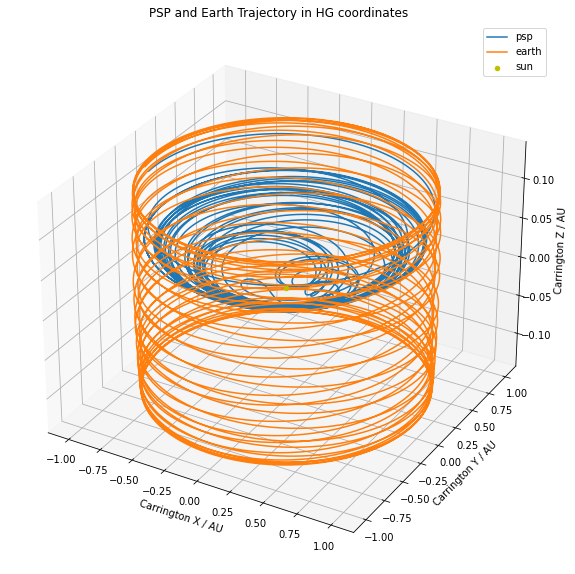

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')


_ = ax.plot3D(psp_traj.x.to(u.au), psp_traj.y.to(u.au), psp_traj.z.to(u.au), label="psp")
_  = ax.plot3D(earth_traj.x.to(u.au), earth_traj.y.to(u.au), earth_traj.z.to(u.au), label="earth")
_ = ax.scatter3D(0, 0, 0, color="y", label="sun")

_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.set_zlabel("Carrington Z / AU")
_ = ax.legend()

_ = ax.set_title("PSP and Earth Trajectory in HG coordinates")
# plt.savefig('figures/'+ case_study + '/psp_cr2210_trajectory_location.png')

# Plot the distance between PSP and Earth in HG coordinates

In [7]:
theta_diff = np.abs(psp_traj.coords.lat - earth_traj.coords.lat)

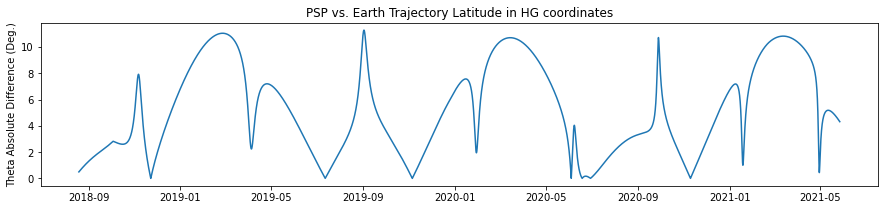

In [8]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(times, theta_diff)
_ = ax.set_ylabel("Theta Absolute Difference (Deg.)")
_ = ax.set_title("PSP vs. Earth Trajectory Latitude in HG coordinates")


## Find local minima

In [9]:
min_index = argrelextrema(theta_diff, np.less)

In [10]:
times[min_index]

array(['2018-10-16T06:00:00.000000', '2018-11-22T15:00:00.000000',
       '2019-04-05T11:00:00.000000', '2019-07-12T15:00:00.000000',
       '2019-11-05T11:00:00.000000', '2020-01-29T17:00:00.000000',
       '2020-06-03T20:00:00.000000', '2020-06-18T09:00:00.000000',
       '2020-06-29T08:00:00.000000', '2020-11-09T09:00:00.000000',
       '2021-01-18T02:00:00.000000', '2021-04-29T18:00:00.000000'],
      dtype='datetime64[us]')

array([2.59873122e+00, 5.86812793e-04, 2.23861316e+00, 1.83538757e-03,
       2.61967650e-04, 1.94913920e+00, 6.74875879e-03, 6.25770084e-04,
       8.72738075e-04, 1.83056631e-03, 9.96621646e-01, 4.41013926e-01])

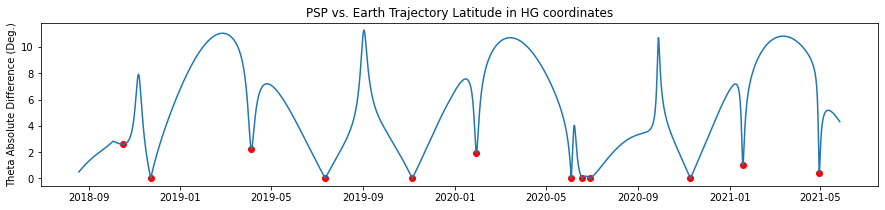

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(times, theta_diff)
_ = ax.scatter(times[min_index], theta_diff[min_index], c="r")
_ = ax.set_ylabel("Theta Absolute Difference (Deg.)")
_ = ax.set_title("PSP vs. Earth Trajectory Latitude in HG coordinates")


theta_diff[min_index].value

# Results:

'2018-10-16T08:00:00.000000', '2018-11-22T15:00:00.000000',
       '2019-04-05T09:00:00.000000', '2019-07-12T17:00:00.000000',
       '2019-11-05T13:00:00.000000'

# Solar Orbiter

The routines in this module can be used to load data from the Solar Orbiter (SOLO) mission. Solo was launched in February 9, 2020, 8:03 PM PST.


Instruments
-----------------
Magnetometer (MAG)

Energetic Particle Detector (EPD)

Radio and Plasma Waves (RPW)

Solar Wind Plasma Analyser (SWA)


In [12]:
starttime = dt.datetime(year=2020, month=3, day=1)
endtime = dt.datetime(year=2021, month=5, day=27)
deltatime = dt.timedelta(hours=1)

times = np.arange(starttime, endtime, deltatime)

In [13]:
orbiter_kernel = spicedata.get_kernel('solo')
spice.furnish(orbiter_kernel)
orbiter = spice.Trajectory('Solar Orbiter')

orbiter.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
solo_coords = orbiter.coords

In [14]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

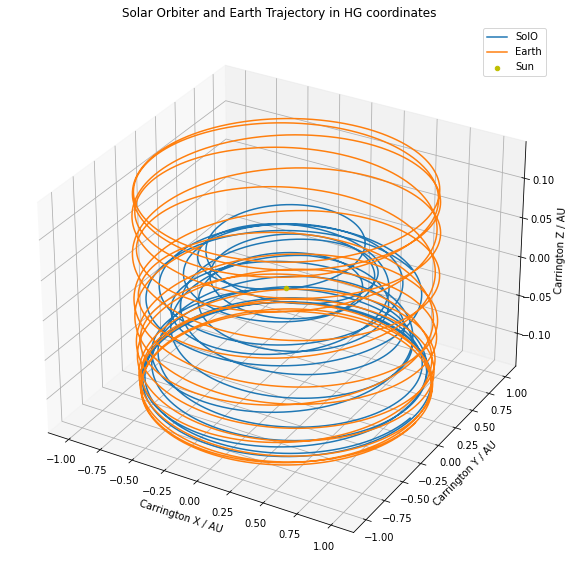

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')


_ = ax.plot3D(orbiter.x.to(u.au), orbiter.y.to(u.au), orbiter.z.to(u.au), label="SolO")
_  = ax.plot3D(earth_traj.x.to(u.au), earth_traj.y.to(u.au), earth_traj.z.to(u.au), label="Earth")
_ = ax.scatter3D(0, 0, 0, color="y", label="Sun")

_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.set_zlabel("Carrington Z / AU")
_ = ax.legend()

_ = ax.set_title("Solar Orbiter and Earth Trajectory in HG coordinates")
# plt.savefig('figures/'+ case_study + '/psp_cr2210_trajectory_location.png')

In [16]:
theta_diff_s = np.abs(orbiter.coords.lat - earth_traj.coords.lat)
min_index_s = argrelextrema(theta_diff_s, np.less)

array([0.00445758, 0.00268091])

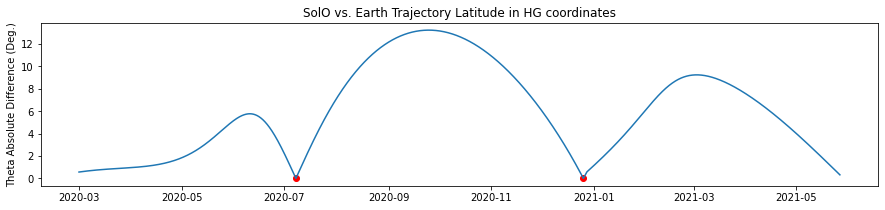

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(times, theta_diff_s)
_ = ax.scatter(times[min_index_s], theta_diff_s[min_index_s], c="r")
_ = ax.set_ylabel("Theta Absolute Difference (Deg.)")
_ = ax.set_title("SolO vs. Earth Trajectory Latitude in HG coordinates")


theta_diff_s[min_index_s].value

In [18]:
times[min_index_s]

array(['2020-07-07T20:00:00.000000', '2020-12-25T14:00:00.000000'],
      dtype='datetime64[us]')

In [ ]:
# explore: CR2232	2020 Jun 18 to 2020 Jul 15 and CR
            